# Control Systems Tutorial 
## Part B: Control tuning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import control as ct
import control.optimal as opt
# from scipy.integrate import solve_ivp
from source.cablecar_model import cablecar_ode, cablecar_output

# System parameters 
M = 0.5; m1 = 5; m2 = 0.1; l = 2.0; g = 9.81; b1 = 2.0; b2 = 0.2; r = 0.02

cablecar_params = {
    "M": M,           # mass of the trolley
    "m1": m1,         # mass of the cable car
    "m2": m2,         # mass of pendulum rod
    "l": l,         # length of the suspension cable
    "g": g,         # gravitational acceleration
    "b1": b1,       # damping of the slider
    "b2": b2,       # damping of the cable car
    "r" : r         # ??
}

cablecar_sys = ct.nlsys(
    cablecar_ode, cablecar_output, name='cablecar',
    params=cablecar_params, states=['theta', 'omega', 'x', 'v'],
    outputs=['phi', 'omega', 'x', 'v'], inputs=['F'])
print(f"Stable steady state at x")
x0, u0 = [-0.1, 0.0, 0.0, 0.0], [0.0]
xeq, ueq = ct.find_operating_point(cablecar_sys, x0, u0)
cablecar_sys_linear = ct.linearize(cablecar_sys, xeq, ueq) 


### Manual tuning of PID

__Task:__ Manually tune a PID controller for the cable car's position control.

#### System model 

We first need to derive the transfer-function of the linearized cable car model for the input *force* to *position*. 
This means we need to compute
$$ G(s)=c_{position}(sI-A)^{-1}b_{force}$$ 

In [37]:
def siso_position(c_sys_lin):
    sys=ct.ss2tf(c_sys_lin, inputs=['F'],outputs=['phi', 'omega', 'x', 'v'])
    return sys[['x'], ['F']]

#### Analyze the transfer function:
*Transfer function*

In [39]:

cable_car_f2x= siso_position(cablecar_sys_linear)
print(cable_car_f2x)


<TransferFunction>: sys[33]$indexed
Inputs (1): ['F']
Outputs (1): ['x']

  4.441e-16 s^3 + 1.818 s^2 + 0.1799 s + 8.915
  --------------------------------------------
     s^4 + 1.371 s^3 + 49.96 s^2 + 1.783 s


#### Define a PID controller by its transfer function

In [224]:
def pid_tf(Kp, Ki, Kd, tau=1e-2):
    if (Kp > 0) and (Ki == 0) and (Kd == 0):
        sys = ct.tf([Kp], [1], inputs=('x',), outputs=('u',))
    elif (Ki > 0) and (Kd > 0) and (tau > 0):
        sys = ct.tf([Kp*tau + Kd, Ki*tau + Kp, Ki], [tau, 1, 0], inputs=('x',), outputs=('u',))
    elif (Kp > 0) and (Kd > 0) and (tau > 0) and (Ki == 0):
        sys = ct.tf([Kp*tau + Kd, Kp], [tau, 1], inputs=('x',), outputs=('u',))
    else:
        sys = ct.tf([Kd, Kp, Ki], [1, 0], inputs=('x',), outputs=('u',))
    return sys

pid_sys = pid_tf(10, 1, 3)
print(pid_sys)


<TransferFunction>: sys[499]
Inputs (1): ['x']
Outputs (1): ['u']

  3.1 s^2 + 10.01 s + 1
  ---------------------
      0.01 s^2 + s


#### Tune the position control

In [225]:
def close_siso_sys(G_p, G_c):
    return G_c*G_p/(1+G_c*G_p)

*Hint:*
- $K_P \in [0.4, 0.8]$
- $K_I$ necessary?
- $K_D \in [5,10]$

In [229]:
pid = pid_tf(0.5,0,7)
closed_sys = close_siso_sys(cable_car_f2x, pid)
closed_sys = closed_sys.minreal()
print(closed_sys)


<TransferFunction>: sys[514]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  3.111e-13 s^5 + 1273 s^4 + 262.4 s^3 + 6261 s^2 + 669.1 s + 15.92
  ------------------------------------------------------------------
  s^6 + 101.4 s^5 + 1464 s^4 + 5267 s^3 + 6618 s^2 + 675.5 s + 15.92


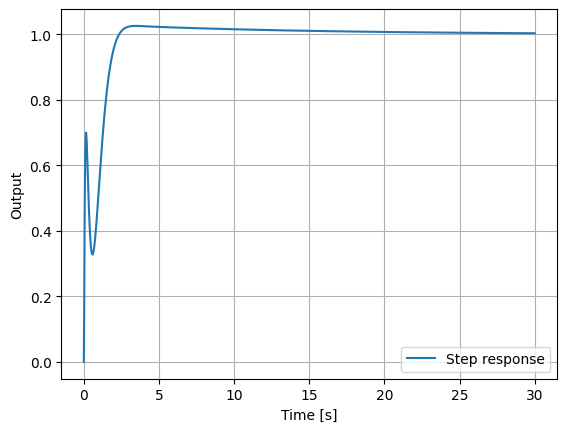

In [230]:
timepts = np.linspace(0, 30, 2000)
t,y = ct.step_response(closed_sys,timepts)

plt.plot(t, y, label=f"Step response")
plt.xlabel("Time [s]")
plt.ylabel("Output")
plt.grid(True)
plt.legend()
plt.show()

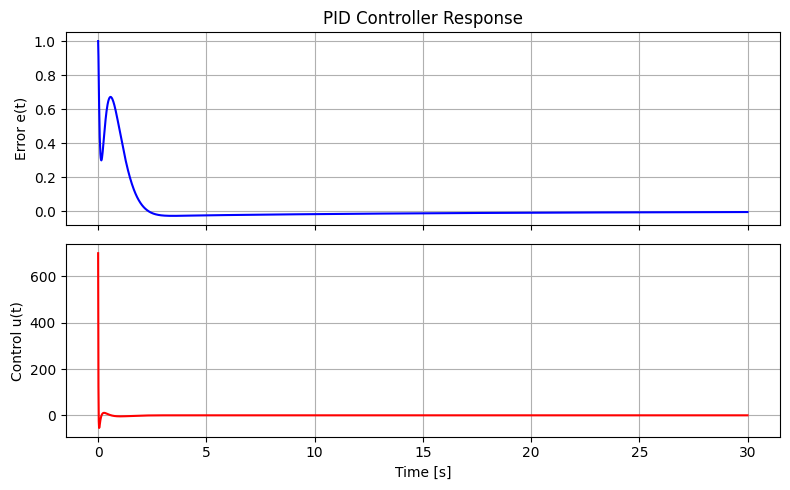

In [231]:
T, e = ct.forced_response(pid, timepts, 1 - y)
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

axs[0].plot(T, 1-y, 'b')
axs[0].set_ylabel("Error e(t)")
axs[0].grid(True)
axs[0].set_title("PID Controller Response")
axs[1].plot(T, e, 'r')
axs[1].set_ylabel("Control u(t)")
axs[1].set_xlabel("Time [s]")
axs[1].grid(True)

plt.tight_layout()
plt.show()

*Question:* Which influence does the constant $\tau$ have on the PD controller?

*Conclusion:* PID tuning from the gut is simulation intense...

### Tuning of PID using root-locus curve

From the previous task we have determined that a PD controller would be adequat. So the structural form of our controller is determined. However, we may could improve the performance by a more analytical approach. 

In [254]:
open_loop = cable_car_f2x*pid_tf(0.5,0,7)
open_loop = open_loop.minreal()
open_loop.poles()

array([-1.00000000e+02+0.j        , -6.67737991e-01+7.03307159j,
       -6.67737991e-01-7.03307159j, -3.57226706e-02+0.j        ,
        0.00000000e+00+0.j        ])

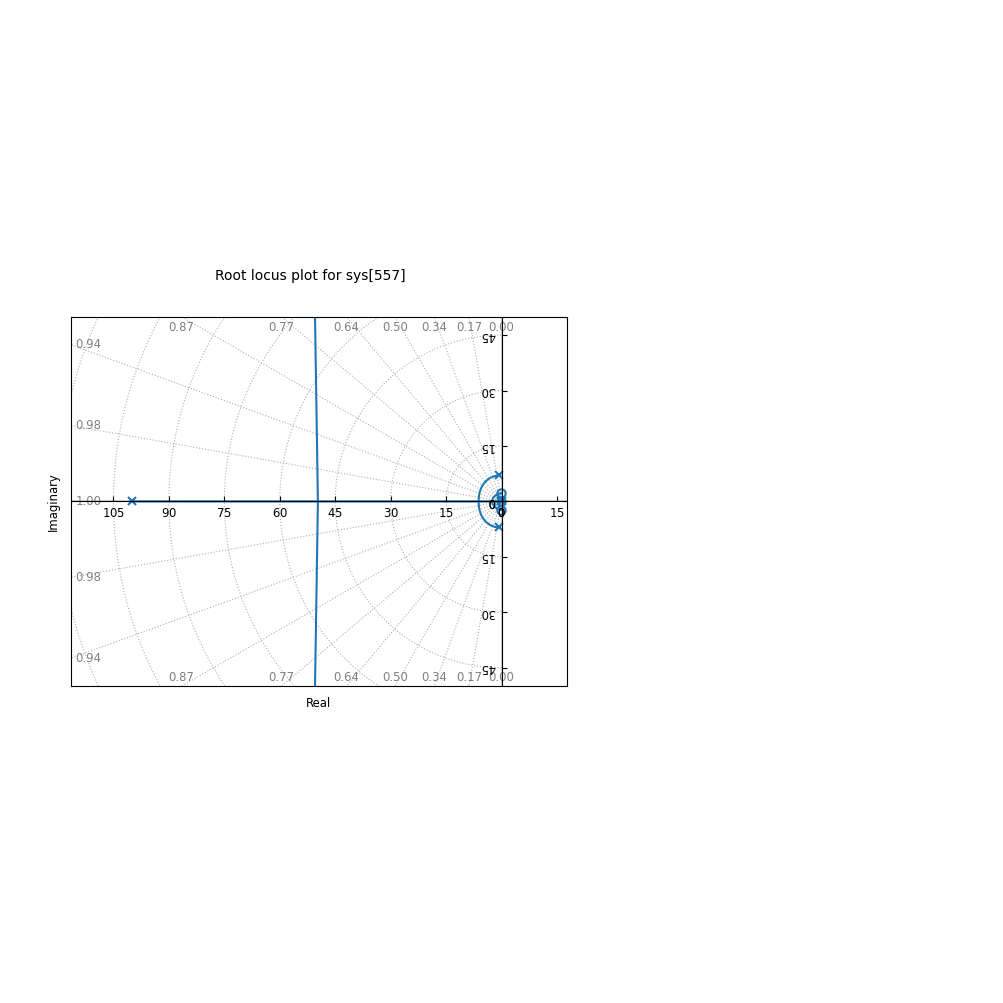

In [ ]:
ct.rlocus(open_loop,  xlim= (-100,1), ylim =(50,-50), interactive=True)

c:\GitFolder\DynamicalPowerSystemSims-Workshop\.conda\Lib\site-packages\scipy\signal\_lti_conversion.py:74: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  num, den = normalize(num, den)   # Strips zeros, checks arrays
c:\GitFolder\DynamicalPowerSystemSims-Workshop\.conda\Lib\site-packages\control\bdalg.py:431: FutureWarning: connect() is deprecated; use interconnect()
  warn("connect() is deprecated; use interconnect()", FutureWarning)


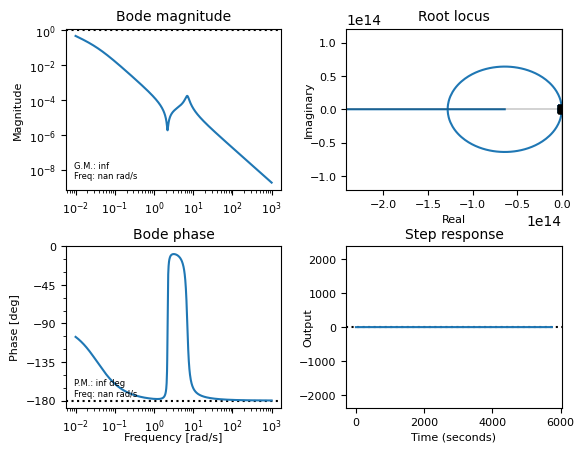

In [266]:
import matplotlib.pyplot as mplt
mplt.isinteractive()
with mplt.ion():
    ct.rootlocus_pid_designer(cable_car_f2x)